# SageMaker Clarify Demo

This demo is designed to outline the stages during the machine learning lifecycle in which SageMaker Clarify can be used. In this case, we look at the pre-training and post-training metrics for measuring bias/fairness and mitigate bias. 

In this notebook we will:

1. **Detect bias using pre-training metrics**: We investigate 8 pre-training metrics where each measure corresponds to a different notion of fairness. It is important to be conscious of the context when interpreting each of the metrics. 
2. Fit a Linear Learner model with SageMaker
3. **Detect bias using post-training metrics**: We investigate 11 post-training metrics. 
4. Evaluating the prediction performance: We look at the accuracy and AUC. This also assists in determining the most appropriate method to mitigate bias. 
5. **Mitigate the bias**: We use one method to mitigate bias. 


We follow the framework given in `https://pages.awscloud.com/rs/112-TZM-766/images/Fairness.Measures.for.Machine.Learning.in.Finance.pdf` which outlines the methodology of first detecting bias, then mitigating the bias. Note that in this example we do not rebalance the sample

![](./img/Flowchart.jpg)

#### Load the packages 

In [1]:
!pip show sagemaker

Name: sagemaker
Version: 2.25.2
Summary: Open source library for training and deploying models on Amazon SageMaker.
Home-page: https://github.com/aws/sagemaker-python-sdk/
Author: Amazon Web Services
Author-email: None
License: Apache License 2.0
Location: /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages
Requires: attrs, boto3, protobuf, google-pasta, importlib-metadata, protobuf3-to-dict, packaging, numpy, smdebug-rulesconfig
Required-by: 


In [2]:
from smclarify.bias.report import *
from smclarify.util.dataset import Datasets, german_lending_readable_values
from typing import Dict
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Load the data

We implement the model pipeline on a canonical sample, i.e.,the well-known German credit dataset. There are $1000$ loan applicants with $20$ features, such as checking account status, loan maturity, credit history, loanpurpose, loan amount, whether the borrower has a savings account and how much balance they carry,  employment status, instalments as a percent of income, gender, otherdebt,  years of residence,  property ownership,  age,  other instalment plans,  rent or own,  number of existing loans, type of job, number of dependents, telephone or not, and whether the person is a foreign worker.

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data', header=None, sep=' ')
df.columns = ["CheckingAC_Status","MaturityMonths","CreditHistory","Purpose","LoanAmount","SavingsAC",
                  "Employment","InstalmentPctOfIncome","SexAndStatus","OtherDebts","PresentResidenceYears",
                  "Property","Age","OtherInstalmentPlans","Housing","NumExistingLoans","Job",
                  "Dependents","Telephone","ForeignWorker","Class1Good2Bad"]
df = german_lending_readable_values(df)

df[['Gender','Status']] = df['SexAndStatus'].str.split(' ',expand=True)
del df['SexAndStatus']
df[['Gender','Status']] = df[['Gender','Status']].astype('object')

#### Data Exploration 

We look at the relationship between variables and detect whether there is class imbalance of the chosen `facet` (in this example we use Gender) and `label` (i.e. target) variable. The label is binary, taking a value 1 if the borrower was classified as a good credit, else it was given a value of 0. 

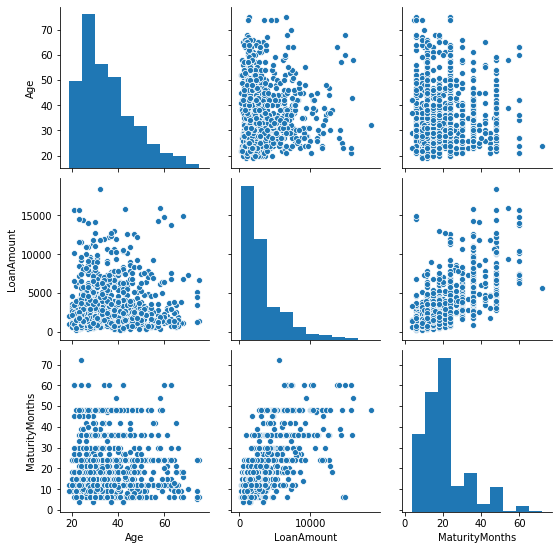

In [4]:
sns.pairplot(df[['Age','LoanAmount','MaturityMonths']])

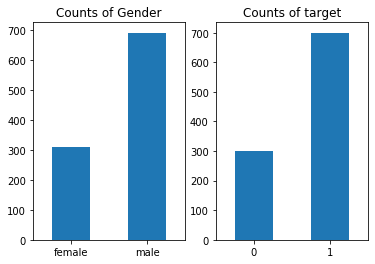

In [5]:
plt.subplot(1, 2, 1)
df['Gender'].value_counts().sort_values().plot(kind='bar', title='Counts of Gender', rot=0)
plt.subplot(1, 2, 2)
df['target'].value_counts().sort_values().plot(kind='bar', title='Counts of target', rot=0)

## Detecting bias: Calculate the pre-training bias metrics

#### Importance of pre-training bias metrics 

Models trained on data biased by demographic disparities might learn and even exacerbate them. To identify bias in the data before expending resources to train models on it, SageMaker Clarify provides data bias metrics that you can compute on raw datasets before training. All of the pretraining metrics are model-agnostic because they do not depend on model outputs and so are valid for any model.


#### Defining the pre-training bias metrics 

Here, the sensitive attribute we are interested in - when determining fairness - is referred to as _facets_. 
The following pre-training metrics are a means of quantifying bias in ML models before the model is even trained. This is the first step to mitigating bias. SageMaker Clarify provides an extensive list of metrics used to measure the difference in the facet value categories. Generally the lower the value the better as it indicates a lower level of difference between the categories. 

| Metric                                    | Description                                                                                                                                       | Range                                                                                       |
|-------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------|
| Class Imbalance (CI)                      | Measures the imbalance in the number of members between different facet values.                                                                   | Normalized range: $[-1,+1]$                                                              |
| Difference in Proportions of Labels (DPL) | Measures the imbalance of positive outcomes between different facet values.                                                                       | normalized binary & multicategory facet labels: $[-1,+1]$; Continuous $[-\infty, +\infty]$  |
| Kullback-Leibler Divergence (KL)          | Measures how much the outcome distributions of different facets diverge from each other entropically.                                             | Range for binary, multicategory, continuous: $[0, +\infty)$                                 |
| Jensen-Shannon Divergence (JS)            | Measures how much the outcome distributions of different facets diverge from each other entropically.                                             | Range for binary, multicategory, continuous: $[0, +\infty)$                                 |
| Lp-norm (LP)                              | Measures a p-norm difference between distinct demographic distributions of the outcomes associated with different facets in a dataset.            | Range for binary, multicategory, continuous: $[0, +\infty)$                                 |
| Total Variation Distance (TVD)            | Measures half of the L1-norm difference between distinct demographic distributions of the outcomes associated with different facets in a dataset. | Range for binary, multicategory, continuous outcomes: $[0, +\infty)$                        |
| Kolmogorov-Smirnov (KS)                   | Measures maximum divergence between outcomes in distributions for different facets in a dataset.                                                  | Range of LP values for binary, multicategory, and continuous outcomes: $[0,+1]$             |
| Conditional Demographic Disparity (CDD)   | Measures the disparity of outcomes between different facets as a whole, but also by subgroups.                                                    | Range of CDD: $[-1, +1]$                                                                    |


The first bias metric examines facet imbalance, but not outcomes. It determines the extent to which the amount of training data is representative across different facets, as desired for the application. The remaining bias metrics compare the distribution of outcome labels in various ways for the facet groups in the data. The metrics that range over negative values can detect negative bias.

#### Assessing the pre-training bias metrics in this example

We should assess the bias metrics on both the training and testing dataset. In the example, we show the results on the full dataset.


In [6]:
# Measure bias for the Gender attribute
facet_column = FacetColumn('Gender')
label_column = LabelColumn('target', df['target'], [1])
group_variable = df['Housing']
report = bias_report(df, facet_column, label_column, stage_type=StageType.PRE_TRAINING, group_variable = group_variable)

In [7]:
def get_metrics(report):
    res = []
    for i in range(len(report)):
        for j in range(len(report[i]['metrics'])):
            if i == 1:
                sex = "female"
            else:
                sex = "male"
            res.append([sex, report[i]['metrics'][j]['name'], report[i]['metrics'][j]['value']])
    return res

In [8]:
metrics = pd.DataFrame(get_metrics(report), columns = ['sex', 'metrics', 'value'] )
metrics

,sex,metrics,value
0,male,CDDL,-0.062079
1,male,CI,-0.380000
2,male,DPL,-0.074801
3,male,JS,0.003728
4,male,KL,0.013311
5,male,KS,0.074801
6,male,LP,0.105785
7,male,TVD,0.074801
8,female,CDDL,0.062079
9,female,CI,0.380000


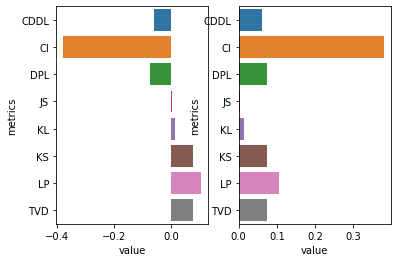

In [9]:
fig, ax =plt.subplots(1,2)
sns.barplot(x = 'value', y= 'metrics',data = metrics[metrics['sex'] == 'male'], ax = ax[0])
sns.barplot(x = 'value', y= 'metrics',data = metrics[metrics['sex'] == 'female'], ax = ax[1])
fig.show()

We see that the $CI = 0.38$ (class imbalance), this is because $31\%$ of the sample comprises of women and so the difference in the proportion of men and women is $0.69 - 0.31 = 0.38$. The other metrics of pre-training biasare milder. $DPL$ shows that imbalance in labels disfavors women (the bias is positive) since the proportion of males ($72\%$ of all males) with a good credit score is higher than the proportion of females ($65\%$ of all females) with a good credit score and thus the difference in the proportions is $7.5\%$. The other measures are also positive but that is because they lie between $0$ and $1$, so may not necessarily reflect bias against women. $JS$, $KL$, $KS$ and $LP$ are test-statistics or distance measures for measuring the difference in probability distributions between males and females.

In [10]:
# Class imbalance calculation 
count_M = sum(df['Gender'] == 'male')
count_F = sum(df['Gender'] == 'female')
n = len(df)

prop_M = count_M/n
prop_F = count_F/n
CI = prop_M - prop_F
print(prop_M, prop_F, CI) 

0.69 0.31 0.37999999999999995


In [11]:
# DPL calculation 
prop_pos_M = len(df[(df['Gender'] == 'male') & (df['target'] ==1)])/count_M
prop_pos_F = len(df[(df['Gender'] == 'female') & (df['target'] ==1)])/count_F
DPL = prop_pos_M - prop_pos_F

print(prop_pos_M, prop_pos_F, DPL)

0.7231884057971014 0.6483870967741936 0.07480130902290782


The demographic disparity metric $(DD)$ determine whether a facet group of `Gender` has a larger proportion of rejected outcomes in the data set than of the accepted outcomes. Here we look at the $DD$ of female.

In [12]:
tot_accept = sum(df['target'] == 1)
tot_reject = sum(df['target'] == 0)

accept_F = len(df[(df['Gender'] == 'female') & (df['target'] ==1)])/ tot_accept 
reject_F = len(df[(df['Gender'] == 'female') & (df['target'] ==0)])/ tot_reject 
DD_F = reject_F - accept_F

print(DD_F)

0.0761904761904762


 A conditional demographic disparity $(CDD)$ metric that conditions $DD$ on attributes that define a strata of subgroups. In this example we condition upon the subgroups of the `group_variable` being `Housing`.
 
 $CDD = \frac{1}{n}\sum_i n_i * DD_i, \quad$  where $\: DD_i = \frac{Number\:of\:rejected\:applicants\:sensitive\:facet}{Total\:number\:of\:rejected\:applicants} -
        \frac{Number\:of\:rejected\:applicants\:sensitive\:facet}{Total\:number\:of\:rejected\:applicants}$ for each group variable $i$, where the group variable is `Housing`.  


## Training the Linear Learner model

Here we train the Linear Learner model. We need to one-hot encode the data, specify the training and dataset, train the model then deploy the model. An optional step that should be considered (before specifying the training and testing dataset) is whether to rebalance the sample or not. 

#### Data encoding 
For this example, data fed into a Linear Learner on Sagemaker was one-hot encoded into a design matrix of binary values. The `target` variables (label) was also moved to the first column. Eventually, we arrived at $63$ features from the the original $22$. 

In [13]:
data = pd.get_dummies(df.drop(['target', 'Gender'], axis=1))
data = data.join(df[['target', 'Gender']])
data = pd.concat([data['target'], data.drop(['target'], axis=1)], axis=1)
data['Gender'].replace({'male': 0, 'female': 1}, inplace=True)

#### Specifying the training and test dataset

Here we split the the dataset into $80:10:10$ for $training:test:validation$. In this example, we will only be using the training dataset to show how to use SageMaker Clarify, but best practice is to train and evaluate the model using testing set and tune the hyperparameters with the validation set

In [14]:
rand_split = np.random.rand(len(data))
train_list = rand_split < 0.8
val_list = (rand_split >= 0.8) & (rand_split < 0.9)
test_list = rand_split >= 0.9

data_train = data[train_list]
data_train.to_csv('train_data.csv', index=False, header=False)
# data_val = data[val_list]
# data_test = data[test_list]

# Extracts all the labels and all the features
train_y = data_train['target']
train_X = data_train.drop(['target'], axis=1)

# val_y = data_val['target']
# val_X = data_val.drop(['target'], axis=1)
# test_y = data_test['target']
# test_X = data_test.drop(['target'], axis=1)

In [15]:
from sagemaker import Session
from sagemaker import get_execution_role
import urllib
import os

session = Session()
bucket = session.default_bucket()
prefix = 'sagemaker/SageMaker-Clarify-Demo'
region = session.boto_region_name

# Define IAM role
role = get_execution_role()

In [16]:
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput

train_uri = S3Uploader.upload('train_data.csv', 's3://{}/{}'.format(bucket, prefix))
train_input = TrainingInput(train_uri, content_type='text/csv')

#test_uri = S3Uploader.upload('test_features.csv', 's3://{}/{}'.format(bucket, prefix))

#### Fitting the logistic regression 

In [ ]:
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator

container = retrieve('linear-learner', region)
linear = Estimator(container,
                role,
                instance_count=1,
                instance_type='ml.m5.large',
                disable_profiler=True,
                sagemaker_session=session)

linear.set_hyperparameters( predictor_type='binary_classifier',
                           mini_batch_size=200)

# fitting the model
linear.fit({'train': train_input})

#### Deploying the Model

In [18]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer

model_name = 'SageMaker-Clarify-Demo'
model = linear.create_model(name=model_name)
container_def = model.prepare_container_def()
session.create_model(model_name,
                     role,
                     container_def)

Using already existing model: SageMaker-Clarify-Demo


'SageMaker-Clarify-Demo'

## Evaluating prediction performance

Here we evaluate the prediction performance by measuring the accuracy and AUC. We also obtain the predicted probabilities which assists in our mitigation strategy. 

In [19]:
# Real-time endpoint:
import sagemaker
from sagemaker.predictor import csv_serializer, json_deserializer
linear_predictor = linear.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large"
    #serializer=sagemaker.serializers.CSVSerializer(),
    #deserializer=sagemaker.deserializers.CSVDeserializer()
    # wait=False,  # Remember, predictor.predict() won't work until deployment finishes!
)

linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

-------------!

In [ ]:
X_train_data = data_train.drop(['target'],axis =1)
X_train = np.array(X_train_data.values).astype('float32')

prediction = []
for tf in X_train:
    prediction.append(linear_predictor.predict(tf))

In [21]:
y_pred = []
pred_probability = []
for ind in range(len(prediction)):
    y_pred.append(prediction[ind]['predictions'][0]['predicted_label'])
    pred_probability.append(prediction[ind]['predictions'][0]['score'])
    
pred_results = pd.concat(
    [   pd.Series(y_pred, name="y_pred", index=data_train.index),
        pd.Series(pred_probability, name="prob", index=data_train.index),
        data_train['Gender'],
        data_train.drop(['Gender'], axis =1),
    ], axis=1
)

pred_results.head()

,y_pred,prob,Gender,target,MaturityMonths,LoanAmount,InstalmentPctOfIncome,PresentResidenceYears,Age,NumExistingLoans,...,Job_unemployed / unskilled-non-resident,Job_unskilled-resident,Telephone_none,Telephone_yes,ForeignWorker_no,ForeignWorker_yes,Status_divorced/separated,Status_divorced/separated/married,Status_married/widowed,Status_single
0,1,0.965458,0,1,6,1169,4,4,67,2,...,0,0,0,1,0,1,0,0,0,1
1,0,0.388062,1,0,48,5951,2,2,22,1,...,0,0,1,0,0,1,0,1,0,0
2,1,0.976079,0,1,12,2096,2,3,49,1,...,0,1,1,0,0,1,0,0,0,1
4,0,0.190360,0,0,24,4870,3,4,53,2,...,0,0,1,0,0,1,0,0,0,1
5,1,0.710588,0,1,36,9055,2,4,35,1,...,0,1,0,1,0,1,0,0,0,1


Moving on, we train the model using logistic regression, achieving an accuracy level of 0.80 and AUC of 0.76

In [22]:
accuracy = sum(pred_results['y_pred'] == pred_results['target'])/len(pred_results)

FP = np.sum((pred_results['y_pred']  == 1) & (pred_results['target'] == 0))
TP = np.sum((pred_results['y_pred']  == 1) & (pred_results['target'] == 1))
FN = np.sum((pred_results['y_pred']  == 0) & (pred_results['target'] == 1))
TN = np.sum((pred_results['y_pred']  == 0) & (pred_results['target'] == 0))
FPR = FP/(FP+TN)
TPR = TP/(TP+FN)
AUC = 1/2 - FPR/2 + TPR/2

print(accuracy, AUC)

0.8022113022113022 0.7564452500266552


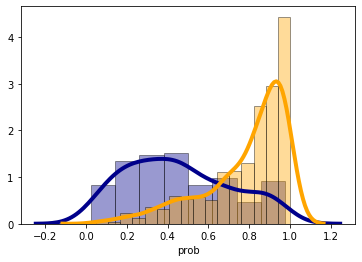

In [23]:
sns.distplot(pred_results.loc[pred_results['target'] == 0, 'prob'], hist=True, kde=True , color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
sns.distplot(pred_results.loc[pred_results['target'] == 1, 'prob'], hist=True, kde=True , color = 'orange', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

## Detecting bias: Calculate the post-training bias metrics

#### Defining the post-training bias metrics 

There are 11 post-training bias metrics provided by SageMaker Clarify:

| Metric                                                        | Description                                                                                                                                                        | Range                                                                                      |
|---------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------|
| Difference in Positive Proportions in Predicted Labels (DPPL) | Measures the difference in the proportion of positive predictions between the favored facet a and the disfavored facet d.                                          | Normalized binary & multicategory facet labels: $[-1,+1]$; Continuous $(-\infty, +\infty)$ |
| Disparate Impact (DI)                                         | Measures the ratio of proportions of the predicted labels for the favored facet a and the disfavored facet d                                                       | Range for normalized binary, multicategory facet, and continuous labels: $[0,\infty)$      |
| Difference in Conditional Acceptance (DCAcc)                  | Compares the observed labels to the labels predicted by a model and assesses whether this is the same across facets for predicted positive outcomes (acceptances). | The range for binary, multicategory facet, and continuous labels: $(-\infty, +\infty)$.    |
| Difference in Conditional Rejection (DCR)                     | Compares the observed labels to the labels predicted by a model and assesses whether this is the same across facets for negative outcomes (rejections).            | The range for binary, multicategory facet, and continuous labels: $(-\infty, +\infty)$.    |
| Recall Difference (RD)                                        | Compares the recall of the model for the favored and disfavored facets.                                                                                            | Range for binary and multicategory classification: $[-1, +1]$.                             |
| Difference in Acceptance Rates (DAR)                          | Measures the difference in the ratios of the observed positive outcomes (TP) to the predicted positives (TP + FP) between the favored and disfavored facets.       | The range for binary, multicategory facet, and continuous labels is $[-1, +1]$.            |
| Difference in Rejection Rates (DRR)                           | Measures the difference in the ratios of the observed negative outcomes (TN) to the predicted negatives (TN + FN) between the disfavored and favored facets.       | The range for binary, multicategory facet, and continuous labels is $[-1, +1]$.            |
| Accuracy Difference (AD)                                      | Measures the difference between the prediction accuracy for the favored and disfavored facets.                                                                     | The range for binary and multicategory facet labels is $[-1, +1]$.                         |
| Treatment Equality (TE)                                       | Measures the difference in the ratio of false positives to false negatives between the favored and disfavored facets.                                              | The range for binary and multicategory facet labels: $(-\infty, +\infty)$.                 |
| Conditional Demographic Disparity in Predicted Labels (CDDPL) | Measures the disparity of predicted labels between the facets as a whole, but also by subgroups.                                                                   | The range of CDDPL values for binary, multicategory, and continuous outcomes: $[-1, +1]$   |
| Counterfactual Fliptest (FT)                                  | Examines each member of facet d and assesses whether similar members of facet a have different model predictions.                                                  | The range for binary and multicategory facet labels is $[-1, +1]$.                         |

Most of these metrics are a combination of the numbers taken from the binary classification confusion matrices for the different demographic groups.

SageMaker Clarify also needs information on what the sensitive columns (`facets`) are, what the sensitive features (`facet_values_or_threshold`) may be, and what the desirable outcomes are (`label_values_or_threshold`). SageMaker Clarify can handle both categorical and continuous data for `facet_values_or_threshold` and for `label_values_or_threshold`. In this case we are using categorical data.

In [24]:
from sagemaker import clarify
bias_report_output_path = 's3://{}/{}/clarify-bias'.format(bucket, prefix)

bias_data_config = clarify.DataConfig(s3_data_input_path=train_uri,
                                      s3_output_path=bias_report_output_path,
                                      label='target',
                                      headers=data_train.columns.to_list(),
                                      dataset_type='text/csv')

model_config = clarify.ModelConfig(model_name=model_name,
                                   instance_type='ml.m5.large',
                                   instance_count=1,
                                   accept_type='text/csv')

predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.8)

bias_config = clarify.BiasConfig(
                    label_values_or_threshold=[1],
                    facet_name='Gender',
                    facet_values_or_threshold=[0]
                )

clarify_processor = clarify.SageMakerClarifyProcessor(
                                role=role,
                                instance_count=1,
                                instance_type='ml.m5.large',
                                sagemaker_session=session
                            )

In [26]:
# report produced by SageMaker Clarify
post_report = clarify_processor.run_bias(data_config=bias_data_config,
                           bias_config=bias_config,
                           model_config=model_config,
                           model_predicted_label_config=predictions_config,
                           pre_training_methods='all',
                           post_training_methods='all')


Job Name:  Clarify-Bias-2021-03-04-04-12-38-369
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-983195105882/sagemaker/SageMaker-Clarify-Demo/train_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-983195105882/sagemaker/SageMaker-Clarify-Demo/clarify-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-983195105882/sagemaker/SageMaker-Clarify-Demo/clarify-bias', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
...........

In [27]:
import boto3
import json

def get_report(my_bucket, my_key, my_file):
    s3 = boto3.client('s3')
    s3.download_file(my_bucket, my_key, my_file)
    with open('analysis.json') as json_file: 
        post_training_report = json.load(json_file)
    post_metrics = []
    post_values = []
    post_dict = post_training_report['post_training_bias_metrics']['facets']['Gender'][0]['metrics']
    for metric in range(len(post_dict)):
        post_metrics.append(post_dict[metric]['name'])
        post_values.append(post_dict[metric]['value'])
    
    return [post_metrics, post_values]


my_bucket = 'sagemaker-us-east-1-983195105882'
my_key = 'sagemaker/SageMaker-Clarify-Demo/clarify-bias/analysis.json'
my_file = 'analysis.json'

post_res = get_report(my_bucket, my_key, my_file)

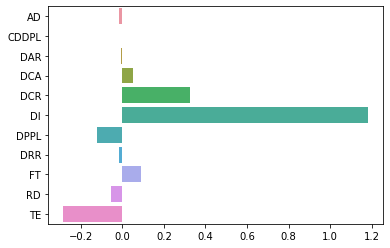

In [28]:
sns.barplot(x = post_res[1], y=post_res[0])

We see that $DCA = 0.049$ indicating that men are given $5\%$ peference relative to women in acceptances. Since $DCR =0.323$, women are $32\%$ disfavored in rejections. A combination of $DCA$ and $DCR$ suggests that the trained model is unfair. The bias metrics suggest that bias mitigation is predicated. 

Note: $DCR = r_d - r_a$, where $r_d = \frac{{n_d}^{(0)}}{ {n'_d}^{(0)}}$ is the ratio of the observed number of negative outcomes of facet $d$ to the predicted number of negative outcome for facet $d$ and likewise for $r_a$. Whereas $DCA$ is the equivalent metric for positive outcomes e.g. $c_d = \frac{{n_d}^{(1)}}{ {n'_d}^{(1)}}$ for facet $d$.

In [29]:
pred_results.head()

,y_pred,prob,Gender,target,MaturityMonths,LoanAmount,InstalmentPctOfIncome,PresentResidenceYears,Age,NumExistingLoans,...,Job_unemployed / unskilled-non-resident,Job_unskilled-resident,Telephone_none,Telephone_yes,ForeignWorker_no,ForeignWorker_yes,Status_divorced/separated,Status_divorced/separated/married,Status_married/widowed,Status_single
0,1,0.965458,0,1,6,1169,4,4,67,2,...,0,0,0,1,0,1,0,0,0,1
1,0,0.388062,1,0,48,5951,2,2,22,1,...,0,0,1,0,0,1,0,1,0,0
2,1,0.976079,0,1,12,2096,2,3,49,1,...,0,1,1,0,0,1,0,0,0,1
4,0,0.190360,0,0,24,4870,3,4,53,2,...,0,0,1,0,0,1,0,0,0,1
5,1,0.710588,0,1,36,9055,2,4,35,1,...,0,1,0,1,0,1,0,0,0,1


$DRR = \frac{TN_d}{(TN_d + FN_d)} - \frac{TN_a}{(TN_a + FN_a)}$ where $d$ is the disfavoured facet and $a$ is the favoured facet

In [30]:
#DRR calculation
FN_a = np.sum((pred_results['Gender'] == 0)&(pred_results['y_pred']  == 0) & (pred_results['target'] == 1))
TN_a = np.sum((pred_results['Gender'] == 0)&(pred_results['y_pred']  == 0) & (pred_results['target'] == 0))

FN_d = np.sum((pred_results['Gender'] == 1)&(pred_results['y_pred']  == 0) & (pred_results['target'] == 1))
TN_d = np.sum((pred_results['Gender'] == 1)&(pred_results['y_pred']  == 0) & (pred_results['target'] == 0))

DRR = TN_a/(TN_a + FN_a) - TN_d/(TN_d + FN_d)
print(DRR)

-0.0044624746450303565


$DPPL = q'_a - q'_d$ where $q'_a = \frac{{n'_a}^{(1)}}{n_a}$ is the predicted proportion of facet $a$ who get a positive outcome of value $1$. If $DPPL$ is close enough to $0$, it means that posttraining demographic parity has been achieved. 


In [31]:
q_M = np.sum((pred_results['Gender'] == 0)&(pred_results['y_pred']  == 0))/ np.sum((pred_results['Gender'] == 0))
q_F = np.sum((pred_results['Gender'] == 1)&(pred_results['y_pred']  == 0))/ np.sum((pred_results['Gender'] == 1))
DPPL = q_M - q_F
print(DPPL)

-0.10347462252137529


#### Optional: Counterfactual analysis

It is possible to flip the gender to see if the distributions of the predicted probabilities changes, i.e., if the protected characteristic influences the model, then the difference in distributions should become smaller. If there is much change in the distribution after the flip test has been conducted then it suggest that the protected characteristic (`facet`) itself does not matter and that the bias arises from other features in the data (this can be done manually by flipping males to $1$ and females to $0$ and then the predicted probabilities can be plotted).


## Mitigating the bias

The method we adopt to mitigate the bias is as follows: We  adjust the labels and retrain the model. Labels were adjusted using a cut-offshift of $\delta= 0.05$, i.e., we relabeled the training data such that for women, any labels that were $0$, but had predicted probabilities greater than $0.45$ i.e. $(H−\delta)$ were labeled as $1$ instead. Likewise, for men, any labels that were $1$ were relabeled as $0$, if the predicted probabilities were less than $0.55$ i.e. $(H+\delta)$. $δ$ needs to be chosen to bring down $DPPL$, $DCA$, $DCR$ as much as possible. This is essentially retraining the model on the features in the training dataset but with new labels.

### Mitigation Approach 1: Relabelling the data and retraining the model

Here we relabel the data using the predicted probabilities. 

In [32]:
H = 0.5
delta = 0.05
H-delta
pred_results.loc[(pred_results['Gender'] == 0) & (pred_results['prob'] > (H - delta)), 'relabel'] = 1
pred_results.loc[(pred_results['Gender'] == 1) & (pred_results['prob'] < (H + delta)), 'relabel'] = 0
pred_results.relabel.fillna(pred_results.target, inplace=True)
pred_results['relabel'] = pred_results['relabel'].astype('int64')

In [33]:
data_train_relabel = pd.concat(  
    [pred_results['relabel'],
    pred_results.drop(['prob', 'y_pred', 'target','relabel'], axis =1)],axis =1 )
data_train_relabel.head()


,relabel,Gender,MaturityMonths,LoanAmount,InstalmentPctOfIncome,PresentResidenceYears,Age,NumExistingLoans,Dependents,CheckingAC_Status_0 <= x < 200 DM,...,Job_unemployed / unskilled-non-resident,Job_unskilled-resident,Telephone_none,Telephone_yes,ForeignWorker_no,ForeignWorker_yes,Status_divorced/separated,Status_divorced/separated/married,Status_married/widowed,Status_single
0,1,0,6,1169,4,4,67,2,1,0,...,0,0,0,1,0,1,0,0,0,1
1,0,1,48,5951,2,2,22,1,1,1,...,0,0,1,0,0,1,0,1,0,0
2,1,0,12,2096,2,3,49,1,2,0,...,0,1,1,0,0,1,0,0,0,1
4,0,0,24,4870,3,4,53,2,2,0,...,0,0,1,0,0,1,0,0,0,1
5,1,0,36,9055,2,4,35,1,2,0,...,0,1,0,1,0,1,0,0,0,1


In [34]:
prefix_relabel = 'sagemaker/SageMaker-Clarify-Demo-relabel'
data_train_relabel.to_csv('train_data_relabel.csv', index=False, header=False)
train_relabel_uri = S3Uploader.upload('train_data_relabel.csv', 's3://{}/{}'.format(bucket, prefix_relabel))
train_relabel_input = TrainingInput(train_relabel_uri, content_type='text/csv')

linear_relabel = Estimator(container,
                role,
                instance_count=1,
                instance_type='ml.m5.large',
                disable_profiler=True,
                sagemaker_session=session)

linear_relabel.set_hyperparameters( predictor_type='binary_classifier',
                           mini_batch_size=200)

linear_relabel.fit({'train': train_relabel_input})

In [36]:
model_name_relabel = 'SageMaker-Clarify-Demo-relabel'
model_relabel = linear_relabel.create_model(name=model_name_relabel)
container_def = model_relabel.prepare_container_def()
session.create_model(model_name_relabel,
                     role,
                     container_def)

Using already existing model: SageMaker-Clarify-Demo-relabel


'SageMaker-Clarify-Demo-relabel'

#### Generating a post-training report after the bias has been mitigated 

In [37]:
bias_report_output_path_relabel = 's3://{}/{}/clarify-bias'.format(bucket, prefix_relabel)

bias_data_config = clarify.DataConfig(s3_data_input_path=train_relabel_uri,
                                      s3_output_path=bias_report_output_path_relabel,
                                      label='relabel',
                                      headers=data_train_relabel.columns.to_list(),
                                      dataset_type='text/csv')

model_config = clarify.ModelConfig(model_name=model_name_relabel,
                                   instance_type='ml.m5.large',
                                   instance_count=1,
                                   accept_type='text/csv')

predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.8)

bias_config = clarify.BiasConfig(
                    label_values_or_threshold=[1],
                    facet_name='Gender',
                    facet_values_or_threshold=[0]
                )

clarify_processor = clarify.SageMakerClarifyProcessor(
                                role=role,
                                instance_count=1,
                                instance_type='ml.m5.large',
                                sagemaker_session=session
                            )

# Will produce the same SageMaker Clarify report as above (has been hidden here)
post_report_relabel = clarify_processor.run_bias(data_config=bias_data_config,
                           bias_config=bias_config,
                           model_config=model_config,
                           model_predicted_label_config=predictions_config,
                           pre_training_methods='all',
                           post_training_methods='all')

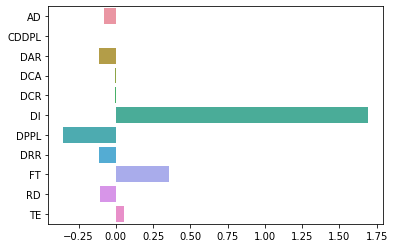

In [39]:
my_bucket_relabel = 'sagemaker-us-east-1-983195105882'
my_key_relabel  = 'sagemaker/SageMaker-Clarify-Demo-relabel/clarify-bias/analysis.json'
my_file_relabel  = 'analysis.json'

post_res_relabel = get_report(my_bucket_relabel, my_key_relabel , my_file_relabel )
sns.barplot(x = post_res_relabel[1], y=post_res_relabel[0])

Some of the metrics have increased and some have decreased and some have flipped (the bias has flipped to disfavour the originally favoured group). The biggest difference we can see is a flip in the bias for $DI$ where before the metric was $>1$ but now it is $<1$ $(DI$ measures the ratio of proportions of the predicted labels for the favored facet a and the disfavored facet d$)$. There is also a decrease in $DCR$ and $DCA$, the difference in the conditional acceptance and rejection from $0.048$ and $0.323$ to practically $0$. $DCA$ and $DCR$ compares the observed labels to the labels predicted by a model and assesses whether this is the same across facets for predicted positive outcomes. 

###  Mitigation Approach 2: Directly adjust the predictions

We now apply the last mitigation approach, though it is hard to see that we can improve on what we have much further. Here, we do not adjust the labels and retrain the model, but instead, we directly adjust the predictions.  We do this by choosing optimally a prediction shift parameter $\eta= 0.045$ and changing all predictions for women between $(H−\eta,H)$ from $0$ to $1$, and for men between $(H,H+\eta)$ to $0$.